In [1]:
# 경고무시
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle
import copy
import random
import time
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib
# from pycaret.classification import *

# PCA 및 군집화 도구
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# 정규화 도구
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer

# 머신러닝(사이킷런)
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, f1_score


def label_to_numeric(x):
        if x=='normal': return 0
        if x=='out':    return 1
        if x=='in':     return 2
        if x=='noise':  return 3
        if x=='other':  return 4


def numeric_to_label(x):
        if x==0: return 'normal'
        if x==1: return 'out'
        if x==2: return 'in'
        if x==3: return 'noise'
        if x==4: return 'other'
            

def f1_score_loss(y_true, y_pred):
    '''
    정상 또는 비정상으로 나누어 f1 socre 계산
    '''

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


def pred_ensemble(pred_1, pred_2, proba_1, proba_2):
    
    pred = []
    proba = []
    for i in range(len(pred_1)):
        if pred_1[i] == pred_2[i]:
            pred.append(pred_1[i])
            proba.append(((proba_1[i] + proba_2[i])/2).tolist())
        else:
            if max(proba_1[i]) > max(proba_2[i]):
                pred.append(pred_1[i])
                proba.append(proba_1[i].tolist())
            else:
                pred.append(pred_2[i])
                proba.append(proba_2[i].tolist())
                
    return pred, np.array(proba)


def plot_train_history(history, final=False, save_dir=None):
    loss = history.history['loss'][:]
    acc = history.history['accuracy'][:]
    if not final:
        val_loss = history.history['val_loss'][:]
        val_acc = history.history['val_accuracy'][:]
    epochs = range(len(loss))
    title = 'Training and validation loss' if not final else 'Training loss'
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    if not final:
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    title = 'Training and validation accuracy' if not final else 'Training accuracy'
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b', label='Training loss')
    if not final:
        plt.plot(epochs, val_acc, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if save_dir:
        plt.savefig(save_dir, dpi=300)
    plt.show()

### 데이터 EDA 및 전처리

In [2]:
# data loding
df = pd.read_csv('train/train.csv')
df.shape

(33600, 514)

In [3]:
df.head(3)

,leaktype,0HZ,10HZ,20HZ,30HZ,40HZ,50HZ,60HZ,70HZ,80HZ,...,5030HZ,5040HZ,5050HZ,5060HZ,5070HZ,5080HZ,5090HZ,5100HZ,5110HZ,5120HZ
0,out,0,2,2,0,2,0,2,2,2,...,2,5,2,2,5,2,2,5,2,5
1,out,0,0,0,3,0,3,0,0,0,...,0,3,3,3,3,3,3,3,3,6
2,out,0,4,4,4,4,5,4,4,5,...,5,5,6,5,6,6,6,5,6,4


In [4]:
df['leaktype'].value_counts()

normal    18000
other      7000
noise      5000
out        1800
in         1800
Name: leaktype, dtype: int64

- **Label 시각화**

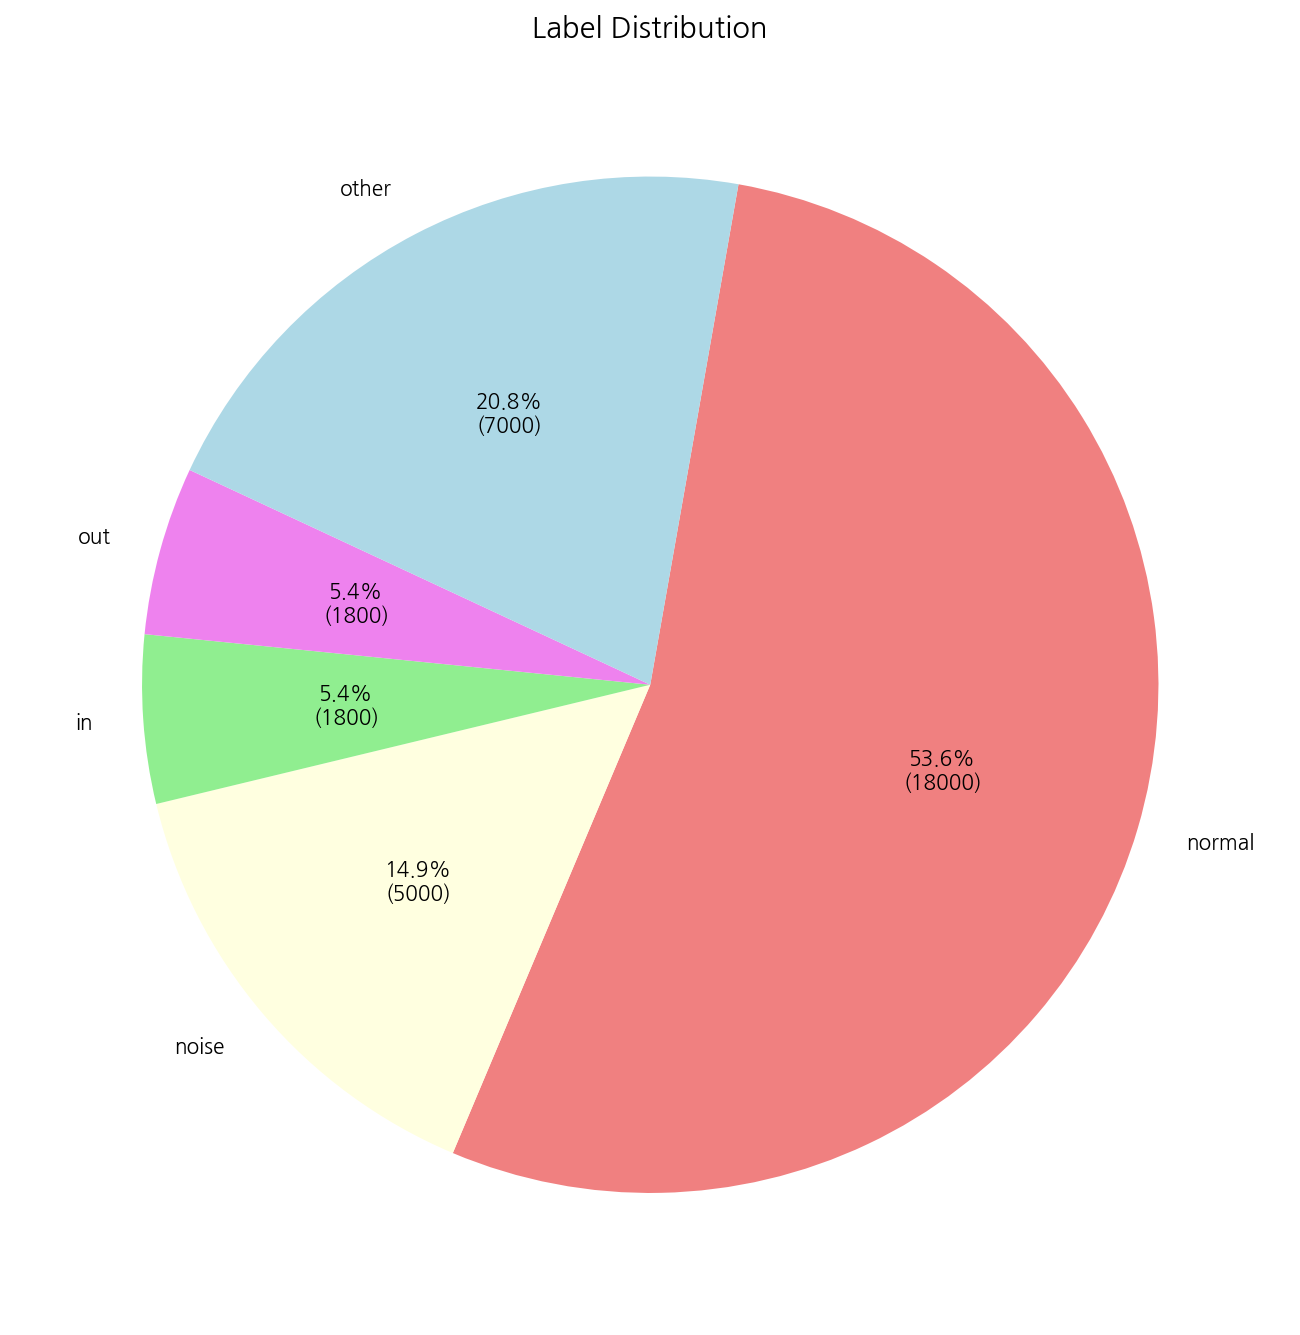

In [5]:
# 비율 및 카운트를 포함한 레이블을 위한 함수
def autopct_generator(counts):
    def autopct(pct):
        total = sum(counts)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%\n({v:d})'.format(p=pct, v=val)
    return autopct

label_counts = df['leaktype'].value_counts()[['normal', 'noise', 'in', 'out', 'other']]

# 파이 차트로 시각화
fig, ax = plt.subplots(figsize=(9, 9))
ax.pie(label_counts, labels=label_counts.index, autopct=autopct_generator(label_counts), startangle=80, counterclock=False, colors=['lightcoral', 'lightyellow', 'lightgreen', 'violet', 'lightblue'])
ax.set_title('Label Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [6]:
df_copy = copy.deepcopy(df)

- **Normalization을 두 가지 방법으로 진행**
    - 컬럼 기준 정규화
    - 로우 기준 정규화

In [7]:
scaler_cn = MinMaxScaler()
scaler_cn.fit(df_copy[df_copy.columns[1:]])
df_copy[df_copy.columns[1:]] = scaler_cn.transform(df_copy[df_copy.columns[1:]]) # 컬럼 기준 정규화
df_cn = copy.deepcopy(df_copy)
# file_name = 'model/minmaxscaler_cn.pkl' 
# joblib.dump(scaler_cn, file_name) 

In [8]:
# scaler = StandardScaler()
scaler_rn = MinMaxScaler()
scaler_rn.fit(df[df.columns[1:]].T)
df[df.columns[1:]] = scaler_rn.transform(df[df.columns[1:]].T).T # 로우 기준 정규화
df_rn = copy.deepcopy(df)
# file_name = 'model/minmaxscaler_rn.pkl' 
# joblib.dump(scaler_rn, file_name) 

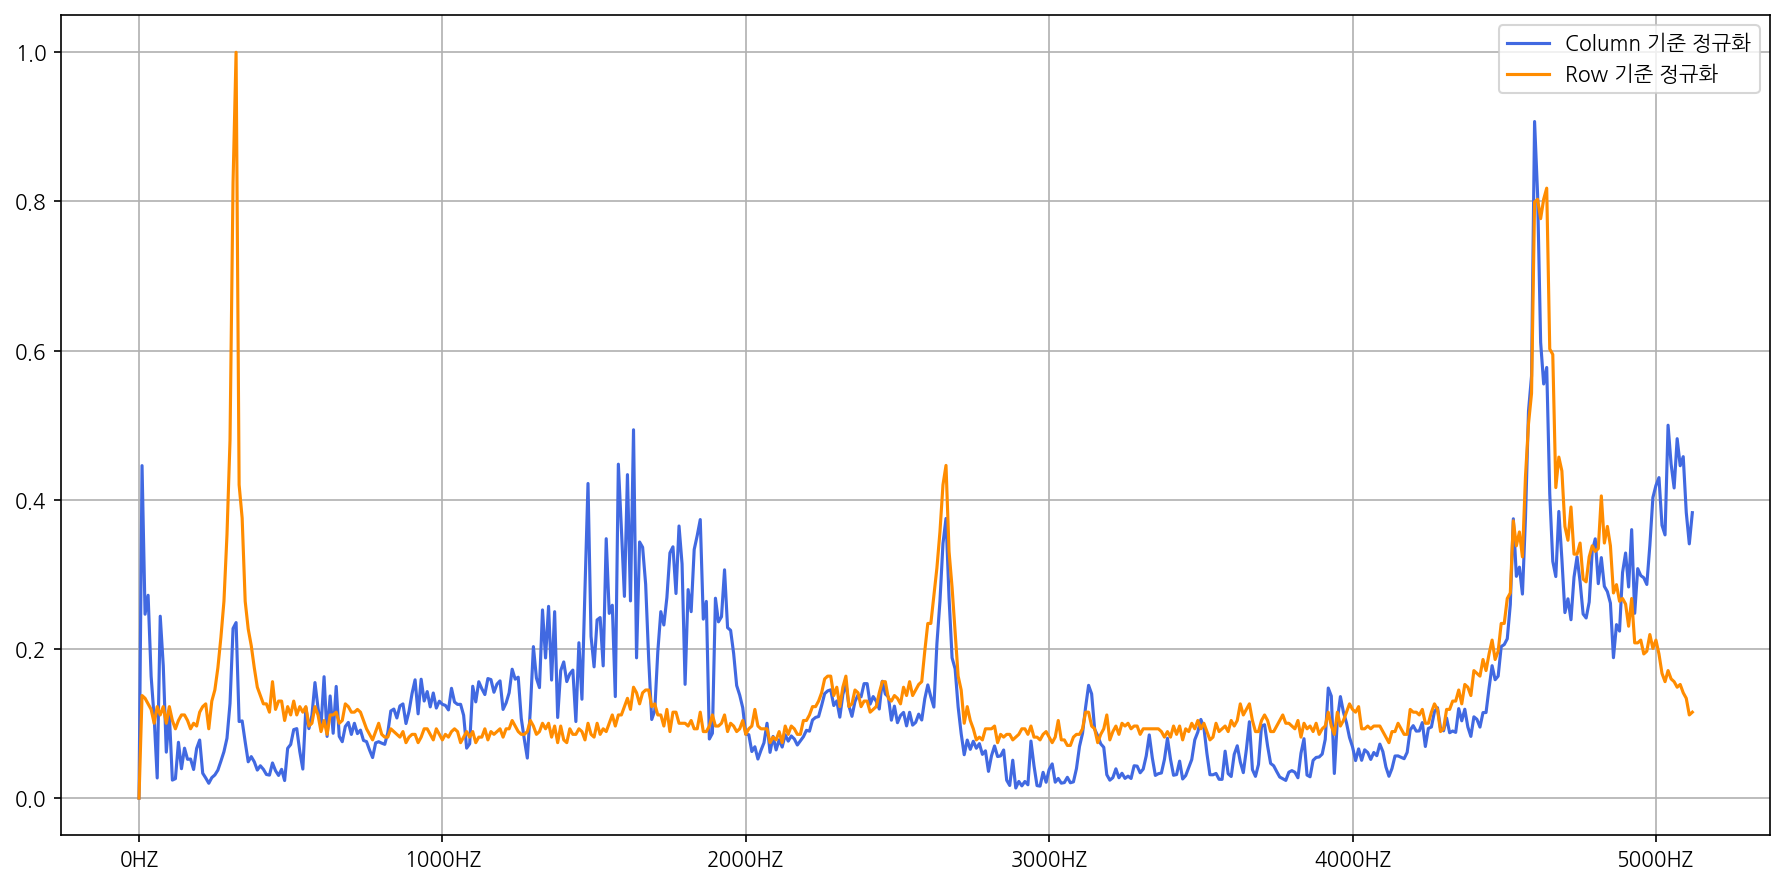

In [10]:
df_cn[df_cn.columns[1:]].iloc[255].plot(subplots=True, figsize=(12, 6), color='royalblue', label='Column 기준 정규화')  # 선의 색상을 녹색으로 설정
df_rn[df_rn.columns[1:]].iloc[255].plot(subplots=True, figsize=(12, 6), color='darkorange', label='Row 기준 정규화')  # 선의 색상을 녹색으로 설정
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig('fig/정규화별비교.png', dpi=300)
plt.show()

- **테스트용 데이터셋으로 각 클래스별 200개씩 추출**

In [10]:
df_cn_0 = df_cn.iloc[np.where(df_cn['leaktype'] == 'out')].sample(n=200, random_state=1234)
df_cn.drop(df_cn_0.index, inplace=True)
df_cn_1 = df_cn.iloc[np.where(df_cn['leaktype'] == 'in')].sample(n=200, random_state=1234)
df_cn.drop(df_cn_1.index, inplace=True)
df_cn_2 = df_cn.iloc[np.where(df_cn['leaktype'] == 'normal')].sample(n=200, random_state=1234)
df_cn.drop(df_cn_2.index, inplace=True)
df_cn_3 = df_cn.iloc[np.where(df_cn['leaktype'] == 'other')].sample(n=200, random_state=1234)
df_cn.drop(df_cn_3.index, inplace=True)
df_cn_4 = df_cn.iloc[np.where(df_cn['leaktype'] == 'noise')].sample(n=200, random_state=1234)
df_cn.drop(df_cn_4.index, inplace=True)

df_rn_0 = df_rn.iloc[np.where(df_rn['leaktype'] == 'out')].sample(n=200, random_state=1234)
df_rn.drop(df_rn_0.index, inplace=True)
df_rn_1 = df_rn.iloc[np.where(df_rn['leaktype'] == 'in')].sample(n=200, random_state=1234)
df_rn.drop(df_rn_1.index, inplace=True)
df_rn_2 = df_rn.iloc[np.where(df_rn['leaktype'] == 'normal')].sample(n=200, random_state=1234)
df_rn.drop(df_rn_2.index, inplace=True)
df_rn_3 = df_rn.iloc[np.where(df_rn['leaktype'] == 'other')].sample(n=200, random_state=1234)
df_rn.drop(df_rn_3.index, inplace=True)
df_rn_4 = df_rn.iloc[np.where(df_rn['leaktype'] == 'noise')].sample(n=200, random_state=1234)
df_rn.drop(df_rn_4.index, inplace=True)

df_cn.shape, df_rn.shape

((32600, 514), (32600, 514))

In [11]:
df_cn_test = pd.concat([df_cn_0, df_cn_1], axis=0)
df_cn_test = pd.concat([df_cn_test, df_cn_2], axis=0)
df_cn_test = pd.concat([df_cn_test, df_cn_3], axis=0)
df_cn_test = pd.concat([df_cn_test, df_cn_4], axis=0)

df_rn_test = pd.concat([df_rn_0, df_rn_1], axis=0)
df_rn_test = pd.concat([df_rn_test, df_rn_2], axis=0)
df_rn_test = pd.concat([df_rn_test, df_rn_3], axis=0)
df_rn_test = pd.concat([df_rn_test, df_rn_4], axis=0)

df_cn_test.shape, df_rn_test.shape

((1000, 514), (1000, 514))

In [12]:
X_cn_train = df_cn[df_cn.columns[1:]]
X_cn_test = df_cn_test[df_cn_test.columns[1:]]

X_rn_train = df_rn[df_rn.columns[1:]]
X_rn_test = df_rn_test[df_rn_test.columns[1:]]

y_train = df_cn[df_cn.columns[0]]
y_test = df_cn_test[df_cn_test.columns[0]]

- **SMOTE 오버샘플링**

In [13]:
# 모델설정
sm = SMOTE(random_state=1234)
X_cn_resampled, y_resampled = sm.fit_resample(X_cn_train, y_train)

sm = SMOTE(random_state=1234)
X_rn_resampled, y_resampled = sm.fit_resample(X_rn_train, y_train)

X_cn_train.shape, X_rn_train.shape, y_train.shape

((32600, 513), (32600, 513), (32600,))

In [14]:
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :', X_cn_train.shape, y_train.shape)
print(f'SMOTE 적용 전 값의 분포 :\n{pd.Series(y_train).value_counts()}')

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : (32600, 513) (32600,)
SMOTE 적용 전 값의 분포 :
normal    17800
other      6800
noise      4800
out        1600
in         1600
Name: leaktype, dtype: int64


In [15]:
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_cn_resampled.shape, y_resampled.shape)
print(f'SMOTE 적용 후 값의 분포 :\n{pd.Series(y_resampled).value_counts()}')

SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (89000, 513) (89000,)
SMOTE 적용 후 값의 분포 :
out       17800
in        17800
normal    17800
other     17800
noise     17800
Name: leaktype, dtype: int64


In [16]:
X_cn_train = copy.deepcopy(X_cn_resampled)
X_rn_train = copy.deepcopy(X_rn_resampled)
y_train = copy.deepcopy(y_resampled)

In [17]:
X_cn_train.shape, X_rn_train.shape, y_train.shape

((89000, 513), (89000, 513), (89000,))

In [18]:
X_cn_test.shape, X_rn_test.shape, y_test.shape

((1000, 513), (1000, 513), (1000,))

### 머신러닝 모델링

- **[KNN] 정규화 방법에 따른 예측성능 비교**

In [19]:
kn_opt_cn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=9, p=2, weights='uniform')
kn_opt_rn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=9, p=2, weights='uniform')
kn_opt_cn.fit(X_cn_train, y_train)
kn_opt_rn.fit(X_rn_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, n_neighbors=9)

In [20]:
# knPickle = open('model/kn_opt_cn.h5', 'wb')
# pickle.dump(kn_opt_cn, knPickle)

# knPickle = open('model/kn_opt_rn.h5', 'wb')
# pickle.dump(kn_opt_rn, knPickle)

In [21]:
y_cn_pred_kn = kn_opt_cn.predict(X_cn_test)
y_cn_proba_kn = kn_opt_cn.predict_proba(X_cn_test)
acc_kn_cn = round(accuracy_score(y_test, y_cn_pred_kn), 2)
f1_kn_cn = f1_score(y_test, y_cn_pred_kn, average='macro')
acc_kn_cn, f1_kn_cn

(0.88, 0.8778725469448106)

In [22]:
y_rn_pred_kn = kn_opt_rn.predict(X_rn_test)
y_rn_proba_kn = kn_opt_rn.predict_proba(X_rn_test)
acc_kn_rn = round(accuracy_score(y_test, y_rn_pred_kn), 2)
f1_kn_rn = f1_score(y_test, y_rn_pred_kn, average='macro')
acc_kn_rn, f1_kn_rn

(0.86, 0.8634696334185359)

- **앙상블 성능증가**

In [23]:
y_pred_kn, y_proba_kn = pred_ensemble(y_cn_pred_kn, y_rn_pred_kn, y_cn_proba_kn, y_rn_proba_kn)
acc_kn = round(accuracy_score(y_test, y_pred_kn), 2)
f1_kn = f1_score(y_test, y_pred_kn, average='macro')
acc_kn, f1_kn

(0.89, 0.8897274963073036)

### 딥러닝 모델링

- **데이터셋 전처리(딥러닝 학습용)**

In [34]:
# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Activation, Dropout, Input, MaxPooling1D, AveragePooling1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras import layers, activations
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import TensorBoard

In [35]:
X_cn_train_dl = copy.deepcopy(X_cn_train.values)
X_rn_train_dl = copy.deepcopy(X_rn_train.values)
X_cn_test_dl = copy.deepcopy(X_cn_test.values)
X_rn_test_dl = copy.deepcopy(X_rn_test.values)

X_cn_train_dl = np.reshape(X_cn_train_dl, (X_cn_train_dl.shape[0],X_cn_train_dl.shape[1],1), order='C')
X_rn_train_dl = np.reshape(X_rn_train_dl, (X_rn_train_dl.shape[0],X_rn_train_dl.shape[1],1), order='C')
X_cn_test_dl = np.reshape(X_cn_test_dl, (X_cn_test_dl.shape[0],X_cn_test_dl.shape[1],1), order='C')
X_rn_test_dl = np.reshape(X_rn_test_dl, (X_rn_test_dl.shape[0],X_rn_test_dl.shape[1],1), order='C')

y_train_dl = copy.deepcopy(pd.DataFrame(y_train)['leaktype'].apply(label_to_numeric))
y_test_dl = copy.deepcopy(pd.DataFrame(y_test)['leaktype'].apply(label_to_numeric))

y_train_dl = to_categorical(y_train_dl, num_classes = 5)
y_test_dl = to_categorical(y_test_dl, num_classes = 5)

In [36]:
X_cn_train_dl.shape, X_rn_train_dl.shape, y_train_dl.shape

((89000, 513, 1), (89000, 513, 1), (89000, 5))

In [37]:
X_cn_test_dl.shape, X_rn_test_dl.shape, y_test_dl.shape

((1000, 513, 1), (1000, 513, 1), (1000, 5))

In [38]:
print(f'tf.__version__: {tf.__version__}')
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)

tf.__version__: 2.9.3
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [39]:
# # Class Weight
# from sklearn.utils.class_weight import compute_class_weight

# y_integers = np.argmax(y_train_dl, axis=1)
# class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
# d_class_weights = dict(enumerate(class_weights))

- **Conv1D 모델 생성 (컬럼 정규화 데이터)**

In [43]:
# seed 고정 (재현성)
random_seed = 1234
tf.keras.utils.set_random_seed(random_seed)
tf.config.experimental.enable_op_determinism()
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = (len(X_cn_train_dl)//32)+1 # 1 Epoch에 32번 가중치 업데이트
Epoch = 3000

model=Sequential()
model.add(Conv1D(64, 9, padding = 'causal', activation='relu', strides=1, input_shape=X_cn_train_dl.shape[-2:]))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(128, 9, padding = 'causal', activation='relu', strides=1))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(256, 9, padding = 'causal', activation='relu', strides=1))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(256, 9, padding = 'causal', activation='relu', strides=1))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(128, 9, padding = 'causal', activation='relu', strides=1))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(64, 9, padding = 'causal', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.35))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(5, activation='softmax'))

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 513, 64)           640       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 256, 64)          0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 256, 64)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 256, 128)          73856     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 128, 128)         0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 128, 128)         

In [45]:
model_name = 'kernel9_drop35_conv1d_cn'
NAME = '{}_{}'.format(model_name,int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=0.00001)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode='max', patience=20, verbose=1)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

multi_step_history = model.fit(X_cn_train_dl,y_train_dl,validation_data=(X_cn_test_dl,y_test_dl),epochs=Epoch,
                               batch_size=batch_size, shuffle=True, callbacks=[earlystopper, tensorboard, reduce_lr])

loss_ = model.evaluate(X_cn_test_dl,y_test_dl)
print("loss :", loss_)

Epoch 1/3000
32/32 [==============================] - 16s 450ms/step - loss: 1.5330 - accuracy: 0.3236 - val_loss: 1.4530 - val_accuracy: 0.4350 - lr: 0.0010
Epoch 2/3000
32/32 [==============================] - 13s 397ms/step - loss: 1.3658 - accuracy: 0.4045 - val_loss: 1.2270 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 3/3000
32/32 [==============================] - 13s 401ms/step - loss: 1.2362 - accuracy: 0.4479 - val_loss: 1.1588 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 4/3000
32/32 [==============================] - 13s 403ms/step - loss: 1.1887 - accuracy: 0.4727 - val_loss: 1.1357 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 5/3000
32/32 [==============================] - 13s 401ms/step - loss: 1.1582 - accuracy: 0.4871 - val_loss: 1.1017 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 6/3000
32/32 [==============================] - 13s 404ms/step - loss: 1.1305 - accuracy: 0.5050 - val_loss: 1.0786 - val_accuracy: 0.5410 - lr: 0.0010
Epoch 7/3000
32/32 [==============================] 

In [46]:
# model.save('model/conv1d_cn.h5')

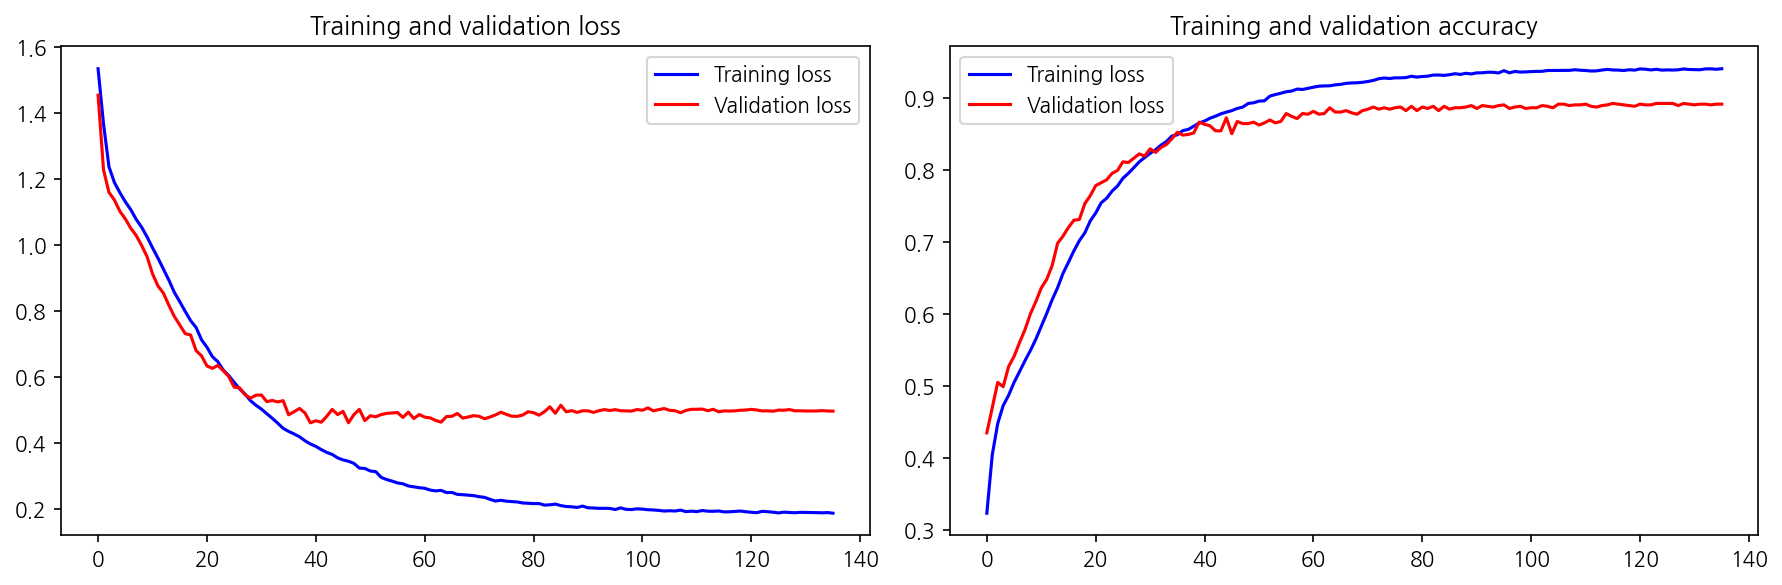

In [48]:
plt.rcParams['figure.figsize'] = (12, 4)
# plot_train_history(multi_step_history, 'fig/conv1d_cn.png')
plot_train_history(multi_step_history)

- **Conv1D (컬럼 정규화 데이터) 예측결과**

In [81]:
y_proba = model.predict(X_cn_test_dl)
y_pred = y_proba.argmax(axis=1)

f1 = round(f1_score(y_test_dl.argmax(axis=1), y_pred, pos_label=0, average='macro'), 4)
acc = round(accuracy_score(y_test_dl.argmax(axis=1), y_pred), 4)
print(f'Acc: {acc}, F1: {f1}')
print('\n', confusion_matrix(y_test_dl.argmax(axis=1), y_pred))

32/32 [==============================] - 0s 3ms/step
Acc: 0.891, F1: 0.8898

 [[199   0   0   0   1]
 [  6 159  13   9  13]
 [  4   8 165  11  12]
 [  3   4   1 181  11]
 [  4   3   2   4 187]]


- **Conv1D 모델 생성 (로우 정규화 데이터)**

In [86]:
# seed 고정 (재현성)
random_seed = 1234
tf.keras.utils.set_random_seed(random_seed)
tf.config.experimental.enable_op_determinism()
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = (len(X_rn_train_dl)//32)+1 # 1 Epoch에 32번 가중치 업데이트
Epoch = 3000

model=Sequential()
model.add(Conv1D(64, 9, padding = 'causal', activation='relu', strides=1, input_shape=X_rn_train_dl.shape[-2:]))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(128, 9, padding = 'causal', activation='relu', strides=1))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(256, 9, padding = 'causal', activation='relu', strides=1))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(256, 9, padding = 'causal', activation='relu', strides=1))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(128, 9, padding = 'causal', activation='relu', strides=1))
model.add(MaxPooling1D(padding = 'valid'))
model.add(Dropout(0.35))
model.add(Conv1D(64, 9, padding = 'causal', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.35))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(5, activation='softmax'))

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 513, 64)           640       
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 256, 64)          0         
 g1D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 256, 64)           0         
                                                                 
 conv1d_25 (Conv1D)          (None, 256, 128)          73856     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 128, 128)         0         
 g1D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 128, 128)         

In [88]:
model_name = 'kernel9_drop35_conv1d_rn'
NAME = '{}_{}'.format(model_name,int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=0.00001)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode='max', patience=20, verbose=1)

opt = tf.keras.optimizers.Adam(learning_rate=0.004)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

multi_step_history = model.fit(X_rn_train_dl,y_train_dl,validation_data=(X_rn_test_dl,y_test_dl),epochs=Epoch,
                               batch_size=batch_size, shuffle=True, callbacks=[earlystopper, tensorboard, reduce_lr])

loss_ = model.evaluate(X_rn_test_dl,y_test_dl)
print("loss :", loss_)

Epoch 1/3000
32/32 [==============================] - 13s 398ms/step - loss: 1.5127 - accuracy: 0.3056 - val_loss: 1.3930 - val_accuracy: 0.3830 - lr: 0.0040
Epoch 2/3000
32/32 [==============================] - 13s 403ms/step - loss: 1.3385 - accuracy: 0.4067 - val_loss: 1.2310 - val_accuracy: 0.4480 - lr: 0.0040
Epoch 3/3000
32/32 [==============================] - 13s 401ms/step - loss: 1.2577 - accuracy: 0.4338 - val_loss: 1.1879 - val_accuracy: 0.4720 - lr: 0.0040
Epoch 4/3000
32/32 [==============================] - 13s 395ms/step - loss: 1.2060 - accuracy: 0.4617 - val_loss: 1.1408 - val_accuracy: 0.4870 - lr: 0.0040
Epoch 5/3000
32/32 [==============================] - 13s 397ms/step - loss: 1.1852 - accuracy: 0.4785 - val_loss: 1.1199 - val_accuracy: 0.5160 - lr: 0.0040
Epoch 6/3000
32/32 [==============================] - 13s 394ms/step - loss: 1.1518 - accuracy: 0.5003 - val_loss: 1.0659 - val_accuracy: 0.5430 - lr: 0.0040
Epoch 7/3000
32/32 [==============================] 

In [89]:
# model.save('model/conv1d_rn.h5')

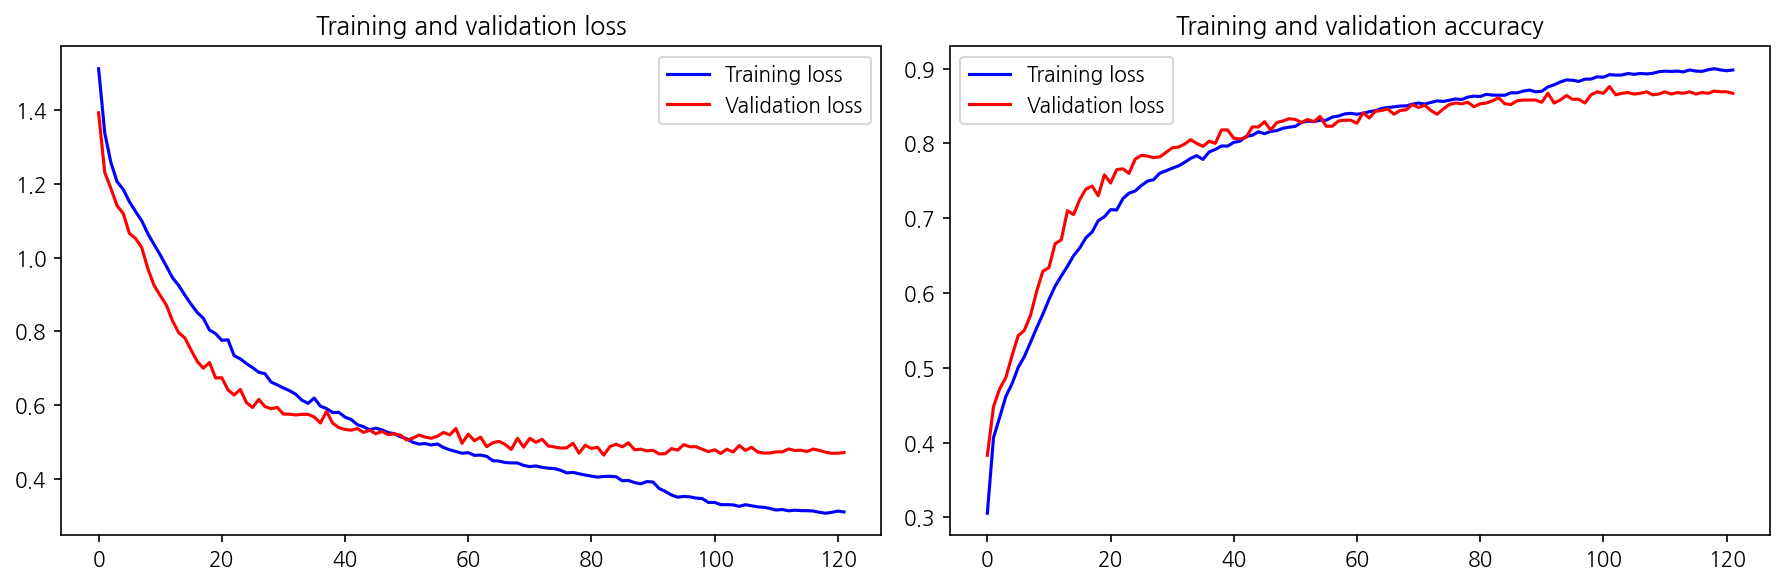

In [90]:
plt.rcParams['figure.figsize'] = (12, 4)
# plot_train_history(multi_step_history, 'fig/conv1d_rn.png')
plot_train_history(multi_step_history)

- **Conv1D (로우 정규화 데이터) 예측결과**

In [92]:
y_proba = model.predict(X_rn_test_dl)
y_pred = y_proba.argmax(axis=1)

f1 = round(f1_score(y_test_dl.argmax(axis=1), y_pred, pos_label=0, average='macro'), 4)
acc = round(accuracy_score(y_test_dl.argmax(axis=1), y_pred), 4)
print(f'Acc: {acc}, F1: {f1}')
print('\n', confusion_matrix(y_test_dl.argmax(axis=1), y_pred))

32/32 [==============================] - 0s 3ms/step
Acc: 0.867, F1: 0.8652

 [[193   0   3   0   4]
 [  3 147  23   9  18]
 [  6  10 156  18  10]
 [  0   3   5 183   9]
 [  2   2   3   5 188]]


- **개별 모델 성능 비교**

In [93]:
knnPickle = open('model/kn_opt_cn.h5', 'rb')
knn_cn = pickle.load(knnPickle)
knnPickle = open('model/kn_opt_rn.h5', 'rb')
knn_rn = pickle.load(knnPickle)

conv1d_cn = tf.keras.models.load_model('model/conv1d_cn.h5')
conv1d_rn = tf.keras.models.load_model('model/conv1d_rn.h5')

- KNN (컬럼 정규화)

In [94]:
y_pred_knn_cn = knn_cn.predict(X_cn_test)
y_proba_knn_cn = knn_cn.predict_proba(X_cn_test)
acc_knn_cn = round(accuracy_score(y_test, y_pred_knn_cn), 2)
f1_knn_cn = f1_score(y_test, y_pred_knn_cn, average='macro')
acc_knn_cn, f1_knn_cn

(0.88, 0.8778725469448106)

- KNN (로우 정규화)

In [96]:
y_pred_knn_rn = knn_rn.predict(X_rn_test)
y_proba_knn_rn = knn_rn.predict_proba(X_rn_test)
acc_knn_rn = round(accuracy_score(y_test, y_pred_knn_rn), 2)
f1_knn_rn = f1_score(y_test, y_pred_knn_rn, average='macro')
acc_knn_rn, f1_knn_rn

(0.86, 0.8634696334185359)

- Conv1D (컬럼 정규화)

In [98]:
y_proba_conv_cn = conv1d_cn.predict(X_cn_test_dl)
y_pred_conv_cn = y_proba_conv_cn.argmax(axis=1)
f1_conv_cn = round(f1_score(y_test_dl.argmax(axis=1), y_pred_conv_cn, pos_label=0, average='macro'), 4)
acc_conv_cn = round(accuracy_score(y_test_dl.argmax(axis=1), y_pred_conv_cn), 4)
acc_conv_cn, f1_conv_cn

32/32 [==============================] - 0s 3ms/step


(0.891, 0.8898)

- Conv1D (로우 정규화)

In [99]:
y_proba_conv_rn = model.predict(X_rn_test_dl)
y_pred_conv_rn = y_proba_conv_rn.argmax(axis=1)
f1_conv_rn = round(f1_score(y_test_dl.argmax(axis=1), y_pred_conv_rn, pos_label=0, average='macro'), 4)
acc_conv_rn = round(accuracy_score(y_test_dl.argmax(axis=1), y_pred_conv_rn), 4)
acc_conv_rn, f1_conv_rn

32/32 [==============================] - 0s 3ms/step


(0.867, 0.8652)

- **앙상블 성능 비교**

In [157]:
y_pred_knn_ensemble, y_proba_knn_ensemble = pred_ensemble(y_pred_knn_cn, y_pred_knn_rn, y_proba_knn_cn, y_proba_knn_rn)
y_pred_conv_ensemble, y_proba_conv_ensemble = pred_ensemble(y_pred_conv_cn, y_pred_conv_rn, y_proba_conv_cn, y_proba_conv_rn)
y_pred_conv_ensemble = pd.DataFrame(y_pred_conv_ensemble)[0].apply(numeric_to_label)
y_pred_ensemble, y_proba_ensemble = pred_ensemble(y_pred_knn_ensemble, y_pred_conv_ensemble, y_proba_knn_ensemble, y_proba_conv_ensemble+0.15)

- KNN 앙상블

In [148]:
acc_knn = round(accuracy_score(y_test, y_pred_knn_ensemble), 2)
f1_knn = f1_score(y_test, y_pred_knn_ensemble, average='macro')
acc_knn, f1_knn

(0.89, 0.8897274963073036)

- Conv1D 앙상블

In [149]:
acc_conv = round(accuracy_score(y_test, y_pred_conv_ensemble), 2)
f1_conv = f1_score(y_test, y_pred_conv_ensemble, average='macro')
acc_conv, f1_conv

(0.9, 0.8957883162513376)

- **전체 앙상블**

In [158]:
acc_ensemble = round(accuracy_score(y_test, y_pred_ensemble), 2)
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='macro')
acc_ensemble, f1_ensemble

(0.9, 0.9009187960337923)

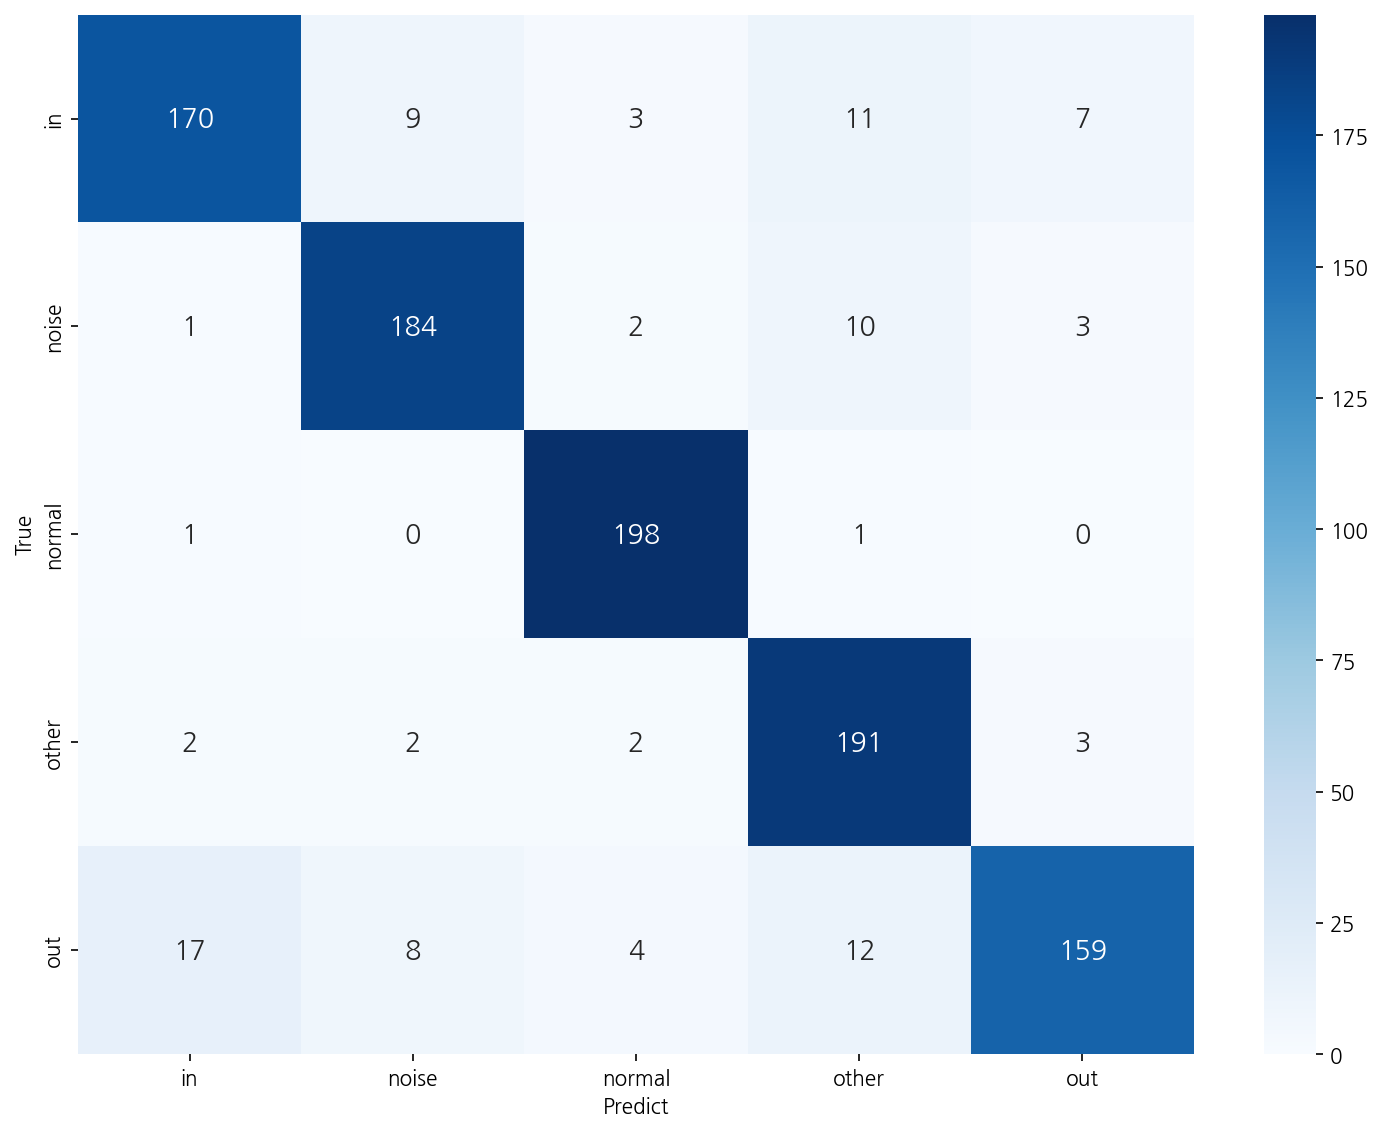

In [171]:
labels = np.unique(y_test).tolist()
plt.figure(figsize=(12,9))
sns.heatmap(confusion_matrix(y_test, y_pred_ensemble, labels = labels), xticklabels = labels,  yticklabels = labels, annot=True, cmap='Blues', fmt='.5g', annot_kws={"size": 13})
plt.xlabel('Predict')
plt.ylabel('True')
plt.show()

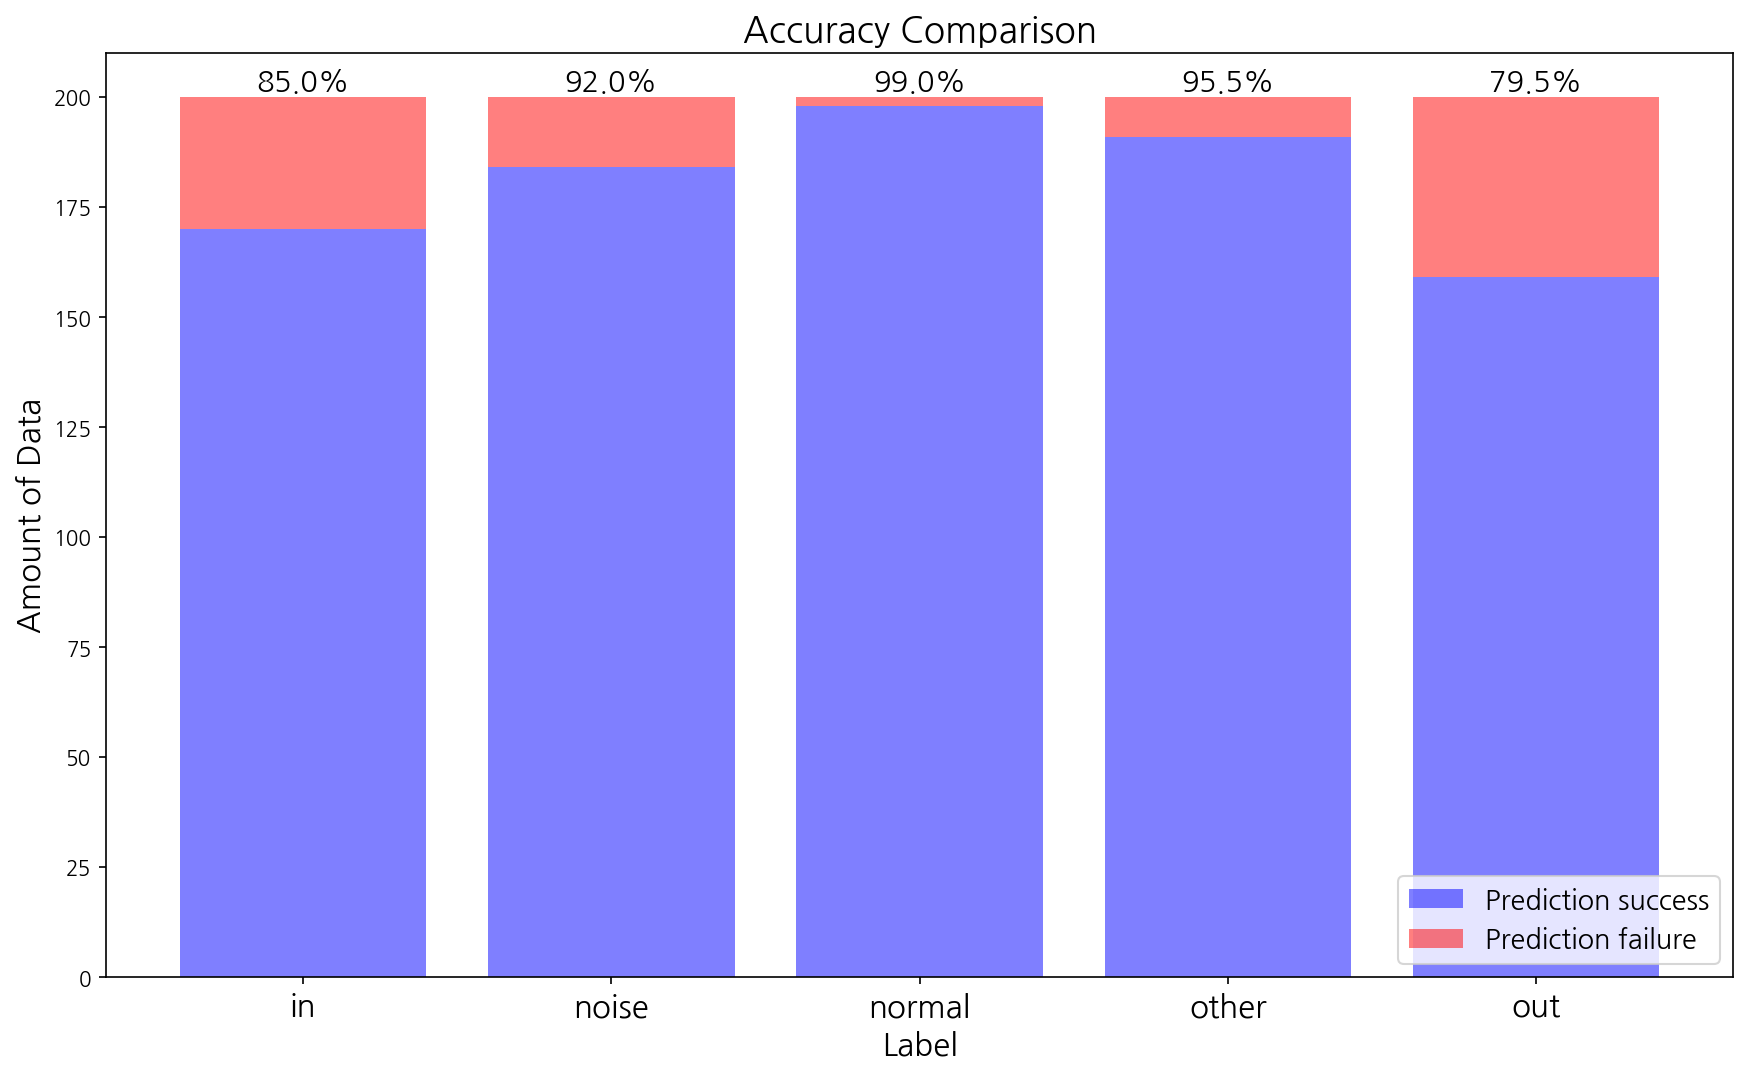

In [169]:
pred_s = []
pred_f = []

for i in range(5):
    pred_s.append(confusion_matrix(y_test, y_pred_ensemble, labels = labels)[i][i])
    pred_f.append(sum(confusion_matrix(y_test, y_pred_ensemble, labels = labels)[i][:]) - confusion_matrix(y_test, y_pred_ensemble, labels = labels)[i][i])

df_s = pd.DataFrame(pred_s)
df_f = pd.DataFrame(pred_f)
percent = []

for i in range(5):
    percent.append(round(confusion_matrix(y_test, y_pred_ensemble, labels = labels)[i][i]/sum(confusion_matrix(y_test, y_pred_ensemble, labels = labels)[i][:]),3))
    
# Bar Chart by 2 categorical variables

# Stacked Bar Chart

label = labels
index = np.arange(5)
alpha = 0.5

plt.figure(figsize=(14,8))
p1 = plt.bar(index, df_s[0], color='b', alpha=alpha)
p2 = plt.bar(index, df_f[0], color='r', alpha=alpha,
            bottom=df_s[0]) # stacked bar chart

plt.title('Accuracy Comparison', fontsize=17)
plt.ylabel('Amount of Data', fontsize=15)
plt.xlabel('Label', fontsize=15)
plt.xticks(index, label, fontsize=15)
plt.legend((p1[0], p2[0]), ('Prediction success', 'Prediction failure'), fontsize=13, loc='lower right')

for i, v in enumerate(index):
    plt.text(v, df_s[0][i]+df_f[0][i], str(round(percent[i]*100,3))+f"%",                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 14, 
             color='black',
             ha='center',  # horizontalalignment (left, center, right)
             va='bottom')    # verticalalignment (top, center, bottom)
    
plt.show()

- 이후 과정
    1. 최종 N개 모델에 테스트셋을 합친 전체 데이터로 학습
    2. 제출용 데이터셋에 대해 예측값을 출력 및 제출

- **ML 모델(KNN) 최적화**

In [172]:
from hyperopt import fmin, tpe, hp, space_eval, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

In [177]:
param_grid_hpopt = {
    
        'KNN'         : {
                          'n_neighbors'         : scope.int(hp.quniform('n_neighbors', 3, 11, 1)),
                          'weights'             : hp.choice('weights', ['uniform','distance']),
                          'algorithm'           : hp.choice('algorithm', ['auto','ball_tree','kd_tree','brute']),
                          'leaf_size'           : scope.int(hp.quniform('leaf_size', 10, 40, 1)),
                          'p'                   : scope.int(hp.quniform('p', 1, 2, 1))
                         }
}

In [178]:
def objective_KNN_CN(params):
    print('Params :', params)
    model = KNeighborsClassifier(**params)
    score = cross_val_score(model, X_cn_train, y_train, cv=5, scoring='accuracy').mean() # 테스트셋 클래스를 동수로 맞추었으므로, Accuracy로 측정
    print('Score : ', score)
    return {'loss':2-score, 'status': STATUS_OK }


def objective_KNN_RN(params):
    print('Params :', params)
    model = KNeighborsClassifier(**params)
    score = cross_val_score(model, X_rn_train, y_train, cv=5, scoring='accuracy').mean() # 테스트셋 클래스를 동수로 맞추었으므로, Accuracy로 측정
    print('Score : ', score)
    return {'loss':2-score, 'status': STATUS_OK }

In [180]:
best = fmin(objective_KNN_CN, param_grid_hpopt['KNN'], algo=tpe.suggest, max_evals=100, trials=Trials())
print("Best Parameters : ", space_eval(param_grid_hpopt['KNN'], best))

Params :                                                                                                                                                                                   
{'algorithm': 'auto', 'leaf_size': 17, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}                                                                                                    
Score :                                                                                                                                                                                    
0.9812696629213482                                                                                                                                                                         
Params :                                                                                                                                                                                   
{'algorithm': 'ball_tree', 'leaf_size': 32, 'n_neighbors': 8

In [182]:
# best = fmin(objective_KNN_RN, param_grid_hpopt['KNN'], algo=tpe.suggest, max_evals=100, trials=Trials())
# print("Best Parameters : ", space_eval(param_grid_hpopt['KNN'], best))